# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [155]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [156]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_now,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [157]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-09 09:00:00+09:00,48035.421875,48179.000000,47995.218750,48075.308594,0,0.0,0.0
2025-10-09 09:15:00+09:00,48076.679688,48334.851562,48062.488281,48280.550781,0,0.0,0.0
2025-10-09 09:30:00+09:00,48276.128906,48362.628906,48244.218750,48247.828125,0,0.0,0.0
2025-10-09 09:45:00+09:00,48245.808594,48423.179688,48245.808594,48415.339844,0,0.0,0.0
2025-10-09 10:00:00+09:00,48408.359375,48444.050781,48349.679688,48390.070312,0,0.0,0.0
2025-10-09 10:15:00+09:00,48385.628906,48398.640625,48253.058594,48368.679688,0,0.0,0.0
2025-10-09 10:30:00+09:00,48366.160156,48407.800781,48320.601562,48377.808594,0,0.0,0.0
2025-10-09 10:45:00+09:00,48381.359375,48481.089844,48327.941406,48439.140625,0,0.0,0.0
2025-10-09 11:00:00+09:00,48436.929688,48440.300781,48275.800781,48330.460938,0,0.0,0.0


## 前日終値の取得

In [158]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-10-02 00:00:00+09:00    44936.730469
2025-10-03 00:00:00+09:00    45769.500000
2025-10-06 00:00:00+09:00    47944.761719
2025-10-07 00:00:00+09:00    47950.878906
2025-10-08 00:00:00+09:00    47734.988281
2025-10-09 00:00:00+09:00    48568.468750
Name: Close, dtype: float64


Date
2025-10-08 00:00:00+09:00    47734.988281
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [159]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+300.43


## ローソク足チャート（小さいサイズ）

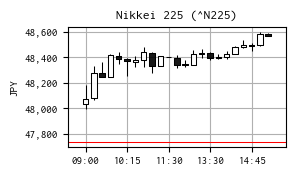

In [160]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [161]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [162]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-08 08:00:00+09:00,151.809006,151.964005,151.787994,151.955002,0,0.0,0.0
2025-10-08 08:15:00+09:00,151.949997,152.093002,151.917007,151.955002,0,0.0,0.0
2025-10-08 08:30:00+09:00,151.957001,152.031006,151.923996,151.977005,0,0.0,0.0
2025-10-08 08:45:00+09:00,151.973007,152.070999,151.953995,152.054993,0,0.0,0.0
2025-10-08 09:00:00+09:00,152.052002,152.335999,152.052002,152.261002,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-09 14:30:00+09:00,152.535995,152.567993,152.522995,152.542999,0,0.0,0.0
2025-10-09 14:45:00+09:00,152.537994,152.656006,152.501007,152.630005,0,0.0,0.0
2025-10-09 15:00:00+09:00,152.632996,152.916000,152.628006,152.893005,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [163]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-10-09 09:00:00+09:00,314.771701,315.712555,314.508254,315.033075
2025-10-09 09:15:00+09:00,315.155661,316.848048,315.062633,316.492091
2025-10-09 09:30:00+09:00,316.496282,317.063372,316.287080,316.310743
2025-10-09 09:45:00+09:00,315.953654,317.115227,315.953654,317.063885
2025-10-09 10:00:00+09:00,317.146966,317.380798,316.762527,317.027145
2025-10-09 10:15:00+09:00,317.357720,317.443063,316.488202,317.246552
2025-10-09 10:30:00+09:00,317.300810,317.573989,317.001928,317.377228
2025-10-09 10:45:00+09:00,317.223615,317.877520,316.873367,317.602471
2025-10-09 11:00:00+09:00,317.554647,317.576748,316.498279,316.856633


### 前日の終値のドル円レートから、前日の終値のドル換算

In [164]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-10-08 15:15:00+09:00


np.float64(152.46400451660156)

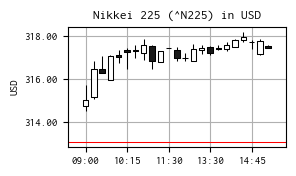

In [165]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()